In [1]:
from itertools import chain
from sklearn import preprocessing

import numpy as np
import pandas as pd
import xgboost as xgb

In [2]:
train_file = "data/train.csv"
test_file = "data/test.csv"
sample_submission = "data/sample_submission.csv"
submission_filename = "xgboost.csv"

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 0,
    'subsample': .85,
    'eta': 0.0275,
    'objective': 'binary:logitraw',
    'num_parallel_tree': 7,
    'max_depth': 5,
    'nthread': 22,
    'eval_metric': 'auc',
}


In [18]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

def get_data():
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    # 370 feather, 76020 training samples
    y_train = train.TARGET
    train = train.drop(['TARGET'], axis=1)
    ntrain = train.shape[0]
    train_test = pd.concat((train, test), axis=0)
    train_test = train_test.drop(['ID'], axis=1)
    train_test = train_test.fillna(-1)
    train_test['NaNCount'] = train_test.apply(lambda x: np.sum(x == -1), axis=1)
    train_test['ZeroCount'] = train_test.apply(lambda x: np.sum(x == 0), axis=1)
    # modify categoricals columns 
    categoricals = [x for x in train_test.columns if train_test[x].dtype == 'object']
    for c in categoricals:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_test[c].values))
        train_test[c] = lbl.transform(list(train_test[c].values))

    train = train_test.iloc[:ntrain, :].copy().reset_index(drop=True)
    test = train_test.iloc[ntrain:, :].copy().reset_index(drop=True)

    features = list(train.columns)
    x_train = train[features].copy()
    x_test = test[features].copy()
    return features, np.array(x_train), np.array(y_train), np.array(x_test)

In [19]:
features, x_train, y_train, x_test = get_data()

In [21]:
ceate_feature_map(features)

In [9]:
ntrain = x_train.shape[0]
best_nrounds = 20
dtrain = xgb.DMatrix(x_train, label=y_train)
evallist  = [(dtrain,'train')]
gbdt = xgb.Booster(model_file='0001.model')

In [24]:
gbdt = xgb.train(xgb_params, dtrain, 2, evallist, verbose_eval =True, xgb_model='0001.model')
#gbdt.save_model('0001.model')

[0]	train-auc:0.959300
[1]	train-auc:0.959312


In [25]:
import operator
importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

In [23]:
df

,feature,fscore
0,imp_trans_var37_ult1,0.002994
1,num_op_var41_ult3,0.002994
2,num_op_var41_efect_ult1,0.002994
3,num_var37,0.002994
4,ind_var26_cte,0.002994
5,saldo_medio_var8_ult3,0.002994
6,saldo_var25,0.002994
7,saldo_var14,0.002994
8,ind_var43_recib_ult1,0.002994
9,num_var4,0.002994


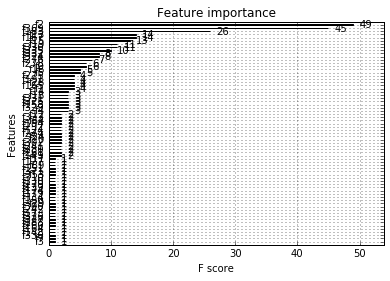

In [17]:
#%matplotlib inline
import matplotlib.pyplot as plt
importance = xgb.plot_importance(gbdt)
plt.show()

In [27]:
dtest=xgb.DMatrix(x_test)
gbdt.predict(dtest)

KeyboardInterrupt: 

In [28]:
submission = pd.read_csv(sample_submission)
submission.iloc[:, 1] = gbdt.predict(dtest).reshape((-1, 1))
submission.to_csv(submission_filename, index=False)